<a href="https://colab.research.google.com/github/infected4098/DSF-/blob/main/Budget_to_act.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 필요 라이브러리 임포트


In [1]:
pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 34.1 MB/s 
     |████████████████████████████████| 465 kB 51.5 MB/s 


In [2]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

Selecting previously unselected package fonts-nanum.
(Reading database ... 124015 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [9]:
#딥러닝 프레임워크
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from statsmodels.formula.api import ols

#전처리, 점수 측정
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#컴퓨터 리소스 할당 관련 
import os
from tqdm.auto import tqdm 

#기초 툴, 시각화
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#기타
import warnings
warnings.filterwarnings("ignore")

#크롤링 및 워드클라우드
from bs4 import BeautifulSoup
import nltk 
from konlpy.tag import *
from konlpy.tag import Twitter
from wordcloud import WordCloud
import urllib.request
from urllib.parse import quote 
import requests
import re
from datetime import datetime
from PIL import *
from collections import Counter
import xml.etree.ElementTree as ET
import json

In [4]:
#드라이브 소싱
from google.colab import drive
drive.mount('/content/gdrive')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#document 위치: /Users/infected4098/Desktop/DSF

Mounted at /content/gdrive


# 노트


In [5]:
"""

내가 해야 할 것
주제의 정당성 데이터 찾기&시각화
예산→인원(회귀)
"""

'\n\n내가 해야 할 것\n주제의 정당성 데이터 찾기&시각화\n예산→인원(회귀)\n'

In [6]:
"""
신체활동지원 : 목욕도움, 세면도움, 식사 도움, 실내이동 도움 등
가사활동지원 : 청소 및 주변정돈, 세탁, 취사 등
사회활동지원 : 등하교 및 출퇴근 보조지원, 외출 동행 등
방문목욕 : 가정방문 목욕제공
방문간호 : 간호, 진료, 요양상담, 구강위생 등
"""

'\n신체활동지원 : 목욕도움, 세면도움, 식사 도움, 실내이동 도움 등\n가사활동지원 : 청소 및 주변정돈, 세탁, 취사 등\n사회활동지원 : 등하교 및 출퇴근 보조지원, 외출 동행 등\n방문목욕 : 가정방문 목욕제공\n방문간호 : 간호, 진료, 요양상담, 구강위생 등\n'

In [7]:
"""
활동보조	수급자의 가정 등을 방문하여 신체활동, 가사활동 및 이동보조 등을 지원	
활동지원사 교육기관에서 교육과정을 수료한 자
[노인복지법]에 따른 요양보호사, [사회복지 사업법]에 따른 사회복지사, [의료법]에 따른 간호사 · 간호조무사 및 유사 경력자* 중 전문과정(32시간), 현장실습(10시간)을 이수한 자
방문목욕	목욕설비를 갖춘 차량을 이용하여 수급자의 가정 등을 방문하여 목욕을 제공	[노인복지법] 에 따른 요양보호사 중 1급 자격을 가진 자
방문간호	의사 · 한의사 · 치과의사의 ‘ 방문간호지시서’ 에 따라 수급자의 가정 등을 방문하여 간호, 진료보조, 요양상담 또는 구강위생 등을 제공	
방문간호사

[의료법]에 따른 간호사로서 2년 이상의 간호업무 경력자
[의료법]에 따른 간호조무사로서 3년 이상의 간호보조업무 경력자 및 [노인장기요양보험법 시행령]제11조제3호나목에 따른 교육이수자
[의료기사 등에 관한 법률]에 따른 치과위생사
"""

'\n활동보조\t수급자의 가정 등을 방문하여 신체활동, 가사활동 및 이동보조 등을 지원\t\n활동지원사 교육기관에서 교육과정을 수료한 자\n[노인복지법]에 따른 요양보호사, [사회복지 사업법]에 따른 사회복지사, [의료법]에 따른 간호사 · 간호조무사 및 유사 경력자* 중 전문과정(32시간), 현장실습(10시간)을 이수한 자\n방문목욕\t목욕설비를 갖춘 차량을 이용하여 수급자의 가정 등을 방문하여 목욕을 제공\t[노인복지법] 에 따른 요양보호사 중 1급 자격을 가진 자\n방문간호\t의사 · 한의사 · 치과의사의 ‘ 방문간호지시서’ 에 따라 수급자의 가정 등을 방문하여 간호, 진료보조, 요양상담 또는 구강위생 등을 제공\t\n방문간호사\n\n[의료법]에 따른 간호사로서 2년 이상의 간호업무 경력자\n[의료법]에 따른 간호조무사로서 3년 이상의 간호보조업무 경력자 및 [노인장기요양보험법 시행령]제11조제3호나목에 따른 교육이수자\n[의료기사 등에 관한 법률]에 따른 치과위생사\n'

# 장애 예산 시각화


In [10]:
#단위는 억 원
#disabled_dict = {"disabled_2015": 18816, "disabled_2016": 19652, "disabled_2017": 20670, "disabled_2018": 22213, "disabled_2019": 27326, "disabled_2020": 32764, "disabled_2021" : 36662, "disabled_2022": 40701}
#자료출처: 보건복지부 기금운영계획안 사업운영계획
#list(disabled_dict.values())
disabled_budget = [4679, 5221, 6061, 6907, 9685, 13057, 15070, 17405]
disabled_index = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
disabled_df = pd.DataFrame(disabled_budget, index=disabled_index, columns=["yearly_budget"])
disabled_df.head()


,yearly_budget
2015,4679
2016,5221
2017,6061
2018,6907
2019,9685


In [11]:
"""
방향성

(1) 장애인 탈시설화 크롤링.. 직관...: 

(2) 장애인 활동지원 크롤링 등... 인원 부족하다.. 

(3) 

#https://www.peoplepower21.org/welfarenow/1847643

"""

'\n방향성\n\n(1) 장애인 탈시설화 크롤링.. 직관...: \n\n(2) 장애인 활동지원 크롤링 등... 인원 부족하다.. \n\n(3) \n\n#https://www.peoplepower21.org/welfarenow/1847643\n\n'

In [12]:
disabled_list = [18816,
19652,
20670,
22213,
27326,
32762,
36662,
40070,

17101,
17755,
18744,
20155,
24731,
29840,
33447,
9731+20930+6541,
6931,
6911,
6927,
7306,
8495,
9180,
9664,
9731,

5496,
6130,
6973,
7902,
11065,
15107,
17704,
20930,

4673,
4715,
4845,
4947,
5171,
5553,
6079,
6541]

disabled_col = ["총계","3대 사업", "장애수당/연금", "장애인 선택적 복지", "장애인복지시설 지원"]

disabled_array = np.array(disabled_list)
disabled_array = disabled_array.reshape(5, -1)

disabled_whole = pd.DataFrame(disabled_array, index=disabled_col, columns=disabled_index)



In [13]:
disabled_whole = disabled_whole.T

disabled_whole

,총계,3대 사업,장애수당/연금,장애인 선택적 복지,장애인복지시설 지원
2015,18816,17101,6931,5496,4673
2016,19652,17755,6911,6130,4715
2017,20670,18744,6927,6973,4845
2018,22213,20155,7306,7902,4947
2019,27326,24731,8495,11065,5171
2020,32762,29840,9180,15107,5553
2021,36662,33447,9664,17704,6079
2022,40070,37202,9731,20930,6541


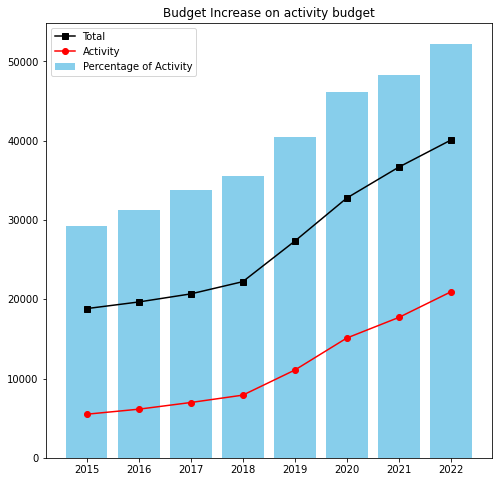

In [14]:
#활동지원비 증가 추세/ 단위는 억 원
fig = plt.figure(figsize=(8,8)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성
ax.plot(disabled_whole.index, disabled_whole["총계"],marker='s', color="black", label='Total') 
ax.bar(disabled_whole.index, disabled_whole["장애인 선택적 복지"]*100*1000/disabled_whole["총계"], color="skyblue", label='Percentage of Activity') #10^3 scaled
ax.plot(disabled_whole.index, disabled_whole["장애인 선택적 복지"], color="red", marker='o',label='Activity') 
ax.legend()
plt.title("Budget Increase on activity budget")
plt.show()


#장애인의 수요자중심적인 정책. 




# '탈시설' 크롤링

In [ ]:
#장애인 선택적 복지의 대부분이 장애인 활동지원사업에 쓰이고 있다는 점을 감안할 때, 장애인 활동지원사업(탈시설화 관련)이 점점 대두되고 있음.

In [ ]:
news_url = 'https://search.naver.com/search.naver?where=news&sm=tab_jum&query={}'
query = "탈시설"
news_num =3000 # 총 필요한 뉴스의 개수
req = requests.get(news_url.format(query))
soup = BeautifulSoup(req.text, 'html.parser')

In [ ]:
news_dict = {}
idx = 0
cur_page = 1


In [ ]:
while idx < news_num:
### 네이버 뉴스 웹페이지 구성이 바뀌어 태그명, class 속성 값 등을 수정함(20210126) ###
    
    table = soup.find('ul',{'class' : 'list_news'})
    li_list = table.find_all('li', {'id': re.compile('sp_nws.*')})
    area_list = [li.find('div', {'class' : 'news_area'}) for li in li_list]
    a_list = [area.find('a', {'class' : 'news_tit'}) for area in area_list]
    
    for n in a_list[:min(len(a_list), news_num-idx)]:
        news_dict[idx] = {'title' : n.get('title'),
                          'url' : n.get('href') }
        idx += 1

    cur_page += 1
    
    pages = soup.find('div', {'class' : 'sc_page_inner'})
    next_page_url = [p for p in pages.find_all('a') if p.text == str(cur_page)][0].get('href')
    
    req = requests.get('https://search.naver.com/search.naver' + next_page_url)
    soup = BeautifulSoup(req.text, 'html.parser')

In [ ]:
print('데이터프레임 변환')
news_df = pd.DataFrame(news_dict).T
news_df

데이터프레임 변환


,title,url
0,탈시설 시범사업 속 장애인 ‘고립’ 대안 시급,http://www.ablenews.co.kr/News/NewsContent.asp...
1,"박희율 광주시의원, 장애인 탈시설 지원조례 발의",http://www.jndn.com/article.php?aid=1668935375...
2,"전장연 시위 멈춘다?...""장애인 예산 6000억 증액""",http://weekly.chosun.com/news/articleView.html...
3,"박희율 시의원, '광주광역시 장애인 탈시설 및 지역사회 정착지원 조례' 대표 발의",http://www.newsworker.co.kr/news/articleView.h...
4,시설수용은 복지서비스 아닌 감금이다,http://www.ablenews.co.kr/News/NewsContent.asp...
...,...,...
2995,"[위드 코로나, 위드 장애인]""시설밖 일상생활 24시간 지원해야""",https://view.asiae.co.kr/article/2021111008214...
2996,장애인등록제 전면 폐지 담은 '장애서비스법' 발의,https://www.beminor.com/news/articleView.html?...
2997,전장연 지하철시위 멈춘 ‘장애인 활동지원’ 예산,https://www.sisa-news.com/news/article.html?no...
2998,"국회, 내년도 예산 확정… 발달장애 예산, 정부안보다 소폭 증가",https://www.beminor.com/news/articleView.html?...


In [ ]:
def word_list(title):
  noun_adj_list = []

  for words in title:
    sentence_list = twitter.pos(words)
    for word, tag in sentence_list:
      if tag in ["Noun", "Adjective"]:
        noun_adj_list.append(word)
      else:
        pass
  return noun_adj_list


In [ ]:
twitter = Twitter()
sentence_list = []





noun_adj = word_list(news_df["title"])
print(noun_adj)

    




['탈', '시설', '시범', '사업', '속', '장애인', '고립', '대안', '시급', '박희', '율', '광주시', '의원', '장애인', '탈', '시설', '지원', '조례', '발의', '장연', '시위', '장애인', '예산', '증액', '박희', '율', '의원', '광주', '광역시', '장애인', '탈', '시설', '및', '지역', '사회', '정착', '지원', '조례', '대표', '발의', '시설', '수용', '복지', '서비스', '아닌', '감금', '임소연', '세기', '가장', '극렬한', '존재', '투쟁', '홍', '전', '서평', '탈', '시설', '외국인', '보호', '폐지', '동물', '해방', '교차로', '정', '임소연', '나', '소중한', '사람', '송', '국현', '홍', '전', '출근길', '천막', '설치', '서울', '지하철', '통', '볼모', '장연', '임소연', '미래', '온', '장애인', '홍', '전', '임소연', '어떤', '갈망', '홍', '전', '임소연', '더하기', '은', '무한대', '홍', '전', '부산시', '복지', '예산', '줄', '삭감', '노인', '장애인', '지원', '사업', '파행', '장애인', '운동', '기후', '정의', '운동', '탈', '시설', '발달장애', '세상', '밖', '연극', '등장인물', '김정하', '처분', '사람', '홍', '전', '선택', '의정서', '비준', '국회', '계류', '올해', '안', '통과', '전문', '유엔', '장애인', '권리', '위원회', '탈', '시설', '가이드라인', '광주', '시공사', '탈', '시설', '장애인', '주거지', '업무', '협약', '김정하', '누구', '배제', '홍', '전', '김정하', '맥심', '커피', '식기', '전', '홍', '전', '탈', '시설', '한국', '피플', '퍼스트', '홍', '

In [ ]:
counts = Counter(noun_adj)
tags = counts.most_common(50)
print(tags)

[('시설', 2486), ('탈', 2130), ('장애인', 1756), ('지원', 627), ('자립', 311), ('정책', 280), ('장연', 276), ('시위', 231), ('장애', 207), ('권리', 192), ('지하철', 191), ('서울시', 191), ('자립생활', 167), ('촉구', 162), ('호선', 155), ('예산', 146), ('보장', 144), ('발달장애', 142), ('단체', 141), ('법', 131), ('사회', 121), ('정부', 116), ('제정', 115), ('거주', 113), ('지역', 111), ('위', 106), ('사업', 97), ('조례', 97), ('개최', 90), ('계획', 89), ('투쟁', 88), ('인권', 88), ('복지', 87), ('로드맵', 87), ('포토', 86), ('추진', 85), ('대구', 85), ('부모', 84), ('인천', 84), ('희망', 75), ('대구시', 75), ('애인', 73), ('제', 72), ('이준석', 71), ('서울', 70), ('마련', 68), ('중', 68), ('주택', 67), ('요구', 67), ('것', 63)]


In [ ]:
#전장연 시위 관련된 단어는 수작업으로 제거 
tags_dict = dict(tags)
#print(tags_dict.keys())
execute_keys = ["시설", "탈", "장연", "지하철", "탈시", "위", "시위", "중", "것"]

useful_dict = {}
for key in tags_dict:
  if key not in execute_keys:
    useful_dict[key] = tags_dict[key]
  
print(useful_dict)

{'장애인': 1756, '지원': 627, '자립': 311, '정책': 280, '장애': 207, '권리': 192, '서울시': 191, '자립생활': 167, '촉구': 162, '호선': 155, '예산': 146, '보장': 144, '발달장애': 142, '단체': 141, '법': 131, '사회': 121, '정부': 116, '제정': 115, '거주': 113, '지역': 111, '사업': 97, '조례': 97, '개최': 90, '계획': 89, '투쟁': 88, '인권': 88, '복지': 87, '로드맵': 87, '포토': 86, '추진': 85, '대구': 85, '부모': 84, '인천': 84, '희망': 75, '대구시': 75, '애인': 73, '제': 72, '이준석': 71, '서울': 70, '마련': 68, '주택': 67, '요구': 67}


In [ ]:
wordcloud = WordCloud(
    font_path = '/content/gdrive/MyDrive/DSF/malgun', background_color='white', colormap='Reds').generate_from_frequencies(useful_dict)

Text(0.5, 1.0, 'Wordcloud')

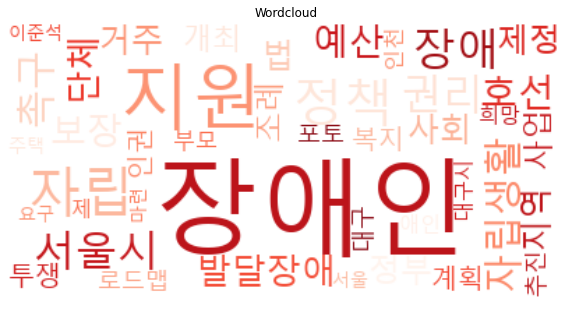

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off') 
plt.title("Wordcloud")


# '장애인 활동지원' 크롤링


In [ ]:
news_url = 'https://search.naver.com/search.naver?where=news&sm=tab_jum&query={}'
query = "장애인 활동지원"
news_num = 1000 # 총 필요한 뉴스의 개수
req = requests.get(news_url.format(query))
soup = BeautifulSoup(req.text, 'html.parser')
news_dict = {}
idx = 0
cur_page = 1

In [ ]:
while idx < news_num:
### 네이버 뉴스 웹페이지 구성이 바뀌어 태그명, class 속성 값 등을 수정함(20210126) ###
    
    table = soup.find('ul',{'class' : 'list_news'})
    li_list = table.find_all('li', {'id': re.compile('sp_nws.*')})
    area_list = [li.find('div', {'class' : 'news_area'}) for li in li_list]
    a_list = [area.find('a', {'class' : 'news_tit'}) for area in area_list]
    
    for n in a_list[:min(len(a_list), news_num-idx)]:
        news_dict[idx] = {'title' : n.get('title'),
                          'url' : n.get('href') }
        idx += 1

    cur_page += 1
    
    pages = soup.find('div', {'class' : 'sc_page_inner'})
    next_page_url = [p for p in pages.find_all('a') if p.text == str(cur_page)][0].get('href')
    
    req = requests.get('https://search.naver.com/search.naver' + next_page_url)
    soup = BeautifulSoup(req.text, 'html.parser')

In [ ]:
print('데이터프레임 변환')
news_df_1 = pd.DataFrame(news_dict).T
news_df_1

데이터프레임 변환


,title,url
0,상지대 발달장애인통합지원센터 ‘더불어 봄’ 1년간 활동 발표회,https://www.pressian.com/pages/articles/202211...
1,"기아, 교통약자 여행 지원 프로그램 10주년 행사 열어",http://news.tf.co.kr/read/economy/1981911.htm
2,"목포신항만운영㈜, 호남지역 발달장애인 볼링대회",https://www.yna.co.kr/view/AKR2022112512310005...
3,"충남도, 발달장애인 위해 5년간 9263억 투입한다",https://news.kmib.co.kr/article/view.asp?arcid...
4,"유럽우주국, 세계 최초로 장애인 우주 비행사 선발",https://biz.chosun.com/science-chosun/science/...
...,...,...
995,"﻿국내기부단체 위브릿지, 장애인 가정 여가문화활동 진행",http://www.datanews.co.kr/news/article.html?no...
996,"현대차, 시각장애인 이동권 향상을 위한 차량 기증",https://www.news1.kr/photos/view/?5662191
997,"""ESG 경영 강화"" 현대캐피탈, 고령층·장애인 맞춤 서비스 확대",http://moneys.mt.co.kr/news/mwView.php?no=2022...
998,"전남도, 관광취약계층 행복여행활동 지원",http://www.netongs.com/news/articleView.html?i...


In [ ]:
twitter = Twitter()
sentence_list = []
noun_adj = word_list(news_df_1["title"])
print(noun_adj)

['상지대', '발달장애', '통합', '지원', '센터', '봄', '활동', '발표회', '기아', '교통', '약자', '여행', '지원', '프로그램', '주년', '행사', '목포신항만', '운영', '호남', '지역', '발달장애', '볼링', '대회', '충남도', '발달장애', '위해', '투입', '유럽우주국', '세계', '최초', '장애인', '우주', '비행사', '선발', '씨앤투스', '대구', '척수', '장애인', '협회', '에르', '마스크', '기부', '경기도', '의회', '복지', '위', '양평', '장애인', '파크', '골프장', '현장', '방문', '인천', '남동구', '구월', '청사', '리', '모델링', '장애인', '직업', '재활', '시설', '운영', '발달장애', '로지원', '혁신', '필요한', '이유', '삼성', '전자', '중증', '장애인', '사회', '자립', '지원', '한국', '앤', '컴퍼니', '장애인', '이동', '장치', '용', '배터리', '지원', '김태흠', '지사', '장애인', '꿈', '희망', '드릴', '것', '킨텍스', '취약', '계층', '위', '김장', '김치', '지원', '상지대', '발달장애', '통합', '지원', '센터', '봄', '활동', '발표회', '광양제철소', '장애인', '힐링', '프로그램', '발대식', '눈길', '기아', '교통', '약자', '여행지', '원하는', '초록', '여행', '주년', '사회', '공헌', '활동', '강화', '저축은행', '창립', '주년', '전국', '각지', '봉사활동', '기술', '보증', '기금', '감사원', '자체', '감사', '활동', '심사', '우수', '기관', '선정', '나', '혼자', '산다', '를', '원합니다', '발달장애', '소연', '말', '명', '발달장애', '답', '주간', '보호', '센터', '성인', '발달장애', '자립',

In [ ]:
counts = Counter(noun_adj)
tags = counts.most_common(50)
print(tags)

[('장애인', 613), ('지원', 247), ('활동', 131), ('발달장애', 105), ('한국', 86), ('사업', 79), ('위', 77), ('사회', 77), ('협약', 72), ('공단', 69), ('고용', 67), ('시각장애인', 63), ('제작', 60), ('센터', 59), ('계층', 57), ('개최', 57), ('시위', 50), ('회', 49), ('복지관', 48), ('업무', 48), ('취약', 46), ('전국', 46), ('경기도', 45), ('지역', 43), ('호선', 43), ('봉사활동', 41), ('단체', 41), ('기회', 40), ('공헌', 39), ('장연', 39), ('후원', 38), ('체결', 38), ('서비스', 36), ('스포츠', 36), ('복지', 35), ('지하철', 35), ('제', 35), ('추진', 34), ('서울', 32), ('청년', 32), ('전달', 32), ('직업', 31), ('자립', 31), ('일자리', 31), ('예산', 31), ('훈련', 31), ('성남시', 31), ('주택', 31), ('장애인체육', 30), ('애인', 30)]


# 예산 인원 수 회귀


In [15]:
disabled_df

,yearly_budget
2015,4679
2016,5221
2017,6061
2018,6907
2019,9685
2020,13057
2021,15070
2022,17405


In [ ]:
import requests

url = 'http://apis.data.go.kr/1352000/ODMS_STAT_18/callStat18Api'
params = {'serviceKey' : 'P17GWD3PsEYIjlKLQZhHbDp7%2FB6PK0nyG2uYMfazEiD%2BTAeBwMc6HdvyA7UBWxpt0uBzAOGSrmCNcco7E0bc%2FA%3D%3D', 'pageNo' : '1', 'numOfRows' : '10', 'apiType' : 'XML', 'year' : '2019', 'dvsd' : '인천' }

response = requests.get(url, params=params)
print(response.content)


b'<OpenAPI_ServiceResponse>\n\t<cmmMsgHeader>\n\t\t<errMsg>SERVICE ERROR</errMsg>\n\t\t<returnAuthMsg>SERVICE_KEY_IS_NOT_REGISTERED_ERROR</returnAuthMsg>\n\t\t<returnReasonCode>30</returnReasonCode>\n\t</cmmMsgHeader>\n</OpenAPI_ServiceResponse>'


In [16]:
encoding = "P17GWD3PsEYIjlKLQZhHbDp7%2FB6PK0nyG2uYMfazEiD%2BTAeBwMc6HdvyA7UBWxpt0uBzAOGSrmCNcco7E0bc%2FA%3D%3D"
year=""
region=""
def make_url(encoding, year, region):
  

  url = "http://apis.data.go.kr/1352000/ODMS_STAT_18/callStat18Api?serviceKey=" + str(encoding) + "numOfRows=20&pageNo=1&apiType=JSON&year="+str(year)+"&dvsd="+str(region)
  return url

url = make_url(encoding, 2017, "인천")

url_2 = "http://apis.data.go.kr/1352000/ODMS_STAT_18/callStat18Api?serviceKey=" + encoding +"&numOfRows=10&pageNo=1&apiType=JSON&year=2019&dvsd=인천"

In [ ]:
response = requests.get(url_2)
json = response.content



In [ ]:
url_2 = "http://apis.data.go.kr/1352000/ODMS_STAT_18/callStat18Api?serviceKey=" + encoding

response = requests.get(url_2)
re_content = response.content


In [ ]:
root = ET.fromstring(re_content)
re_content

# 연도별 장애활동인원 수 확인 (반복 왜 안됨)




In [17]:
url_2015 = "http://apis.data.go.kr/1352000/ODMS_STAT_18/callStat18Api?serviceKey=" + encoding + "&numOfRows=30&pageNo=1&apiType=JSON&year=2015&dvsd=인천"
url_2016 = "http://apis.data.go.kr/1352000/ODMS_STAT_18/callStat18Api?serviceKey=" + encoding + "&numOfRows=30&pageNo=1&apiType=JSON&year=2016"

url_2017 = "http://apis.data.go.kr/1352000/ODMS_STAT_18/callStat18Api?serviceKey=" + encoding + "&numOfRows=30&pageNo=1&apiType=JSON&year=2017"
url_2018 = "http://apis.data.go.kr/1352000/ODMS_STAT_18/callStat18Api?serviceKey=" + encoding + "&numOfRows=30&pageNo=1&apiType=JSON&year=2018"
url_2019 = "http://apis.data.go.kr/1352000/ODMS_STAT_18/callStat18Api?serviceKey=" + encoding + "&numOfRows=30&pageNo=1&apiType=JSON&year=2019"
url_2020 = "http://apis.data.go.kr/1352000/ODMS_STAT_18/callStat18Api?serviceKey=" + encoding + "&numOfRows=30&pageNo=1&apiType=JSON&year=2020"
url_2021 = "http://apis.data.go.kr/1352000/ODMS_STAT_18/callStat18Api?serviceKey=" + encoding + "&numOfRows=30&pageNo=1&apiType=JSON&year=2021"
url_2022 = "http://apis.data.go.kr/1352000/ODMS_STAT_18/callStat18Api?serviceKey=" + encoding + "&numOfRows=30&pageNo=1&apiType=JSON&year=2022"

url_list = [url_2015, url_2016, url_2017, url_2018, url_2019, url_2020, url_2021, url_2022]



In [ ]:
req = requests.get(url_2018)
req.encoding = "utf-8"
text = req.content
print(text)

b'{"pageNo":"1","resultCode":"00","totalCount":51,"items":[{"emsfsFml":"null","acvspMale":"null","acvspTtl":"740","year":"2018","emsfsMale":"null","emsfsTtl":"758","acvspFml":"null","dvsd":"\xea\xb4\x91\xec\xa3\xbc"},{"emsfsFml":"null","acvspMale":"null","acvspTtl":"161","year":"2018","emsfsMale":"null","emsfsTtl":"209","acvspFml":"null","dvsd":"\xec\x9a\xb8\xec\x82\xb0"},{"emsfsFml":"null","acvspMale":"null","acvspTtl":"146","year":"2018","emsfsMale":"null","emsfsTtl":"355","acvspFml":"null","dvsd":"\xec\xa0\x9c\xec\xa3\xbc"},{"emsfsFml":"null","acvspMale":"null","acvspTtl":"1388","year":"2018","emsfsMale":"null","emsfsTtl":"1107","acvspFml":"null","dvsd":"\xeb\xb6\x80\xec\x82\xb0"},{"emsfsFml":"null","acvspMale":"null","acvspTtl":"631","year":"2018","emsfsMale":"null","emsfsTtl":"456","acvspFml":"null","dvsd":"\xec\xa0\x84\xeb\xb6\x81"},{"emsfsFml":"null","acvspMale":"null","acvspTtl":"849","year":"2018","emsfsMale":"null","emsfsTtl":"353","acvspFml":"null","dvsd":"\xea\xb2\xbd\xeb\x

In [18]:
act_dict = {}
ems_dict = {}

In [20]:
n = 0
req = requests.get(url_2015)
year = n+2015

total_act = 0
total_ems = 0

req.encoding = "utf-8"
text = req.content
my_json = text.decode("utf8").replace("'", '"')
data = json.loads(my_json)
for i in range(len(data["items"])):
  total_act += int(data["items"][i]["acvspTtl"])
  total_ems += int(data["items"][i]["emsfsTtl"])
act_dict["year_"+str(year)] = total_act
ems_dict["year_"+str(year)] = total_ems
print(ems_dict)

{'year_2015': 0}


In [21]:
n = 1
req = requests.get(url_2016)
year = n+2015

total_act = 0
total_ems = 0

req.encoding = "utf-8"
text = req.content
my_json = text.decode("utf8").replace("'", '"')
data = json.loads(my_json)
for i in range(len(data["items"])):
  total_act += int(data["items"][i]["acvspTtl"])
  total_ems += int(data["items"][i]["emsfsTtl"])
act_dict["year_"+str(year)] = total_act
ems_dict["year_"+str(year)] = total_ems

print(act_dict)


{'year_2015': 0, 'year_2016': 0}


In [22]:
n = 2
req = requests.get(url_2017)
year = n+2015

total_act = 0
total_ems = 0

req.encoding = "utf-8"
text = req.content
my_json = text.decode("utf8").replace("'", '"')
data = json.loads(my_json)
for i in range(len(data["items"])):
  total_act += int(data["items"][i]["acvspTtl"])
  total_ems += int(data["items"][i]["emsfsTtl"])
act_dict["year_"+str(year)] = total_act
ems_dict["year_"+str(year)] = total_ems

print(act_dict)

{'year_2015': 0, 'year_2016': 0, 'year_2017': 12871}


In [23]:
n = 3
req = requests.get(url_2018)
year = n+2015

total_act = 0
total_ems = 0

req.encoding = "utf-8"
text = req.content
my_json = text.decode("utf8").replace("'", '"')
data = json.loads(my_json)
for i in range(len(data["items"])):
  total_act += int(data["items"][i]["acvspTtl"])
  total_ems += int(data["items"][i]["emsfsTtl"])
act_dict["year_"+str(year)] = total_act
ems_dict["year_"+str(year)] = total_ems

print(act_dict)

{'year_2015': 0, 'year_2016': 0, 'year_2017': 12871, 'year_2018': 14783}


In [24]:
n = 4
req = requests.get(url_2019)
year = n+2015

total_act = 0
total_ems = 0

req.encoding = "utf-8"
text = req.content
my_json = text.decode("utf8").replace("'", '"')
data = json.loads(my_json)
for i in range(len(data["items"])):
  total_act += int(data["items"][i]["acvspTtl"])
  total_ems += int(data["items"][i]["emsfsTtl"])
act_dict["year_"+str(year)] = total_act
ems_dict["year_"+str(year)] = total_ems

print(act_dict)

{'year_2015': 0, 'year_2016': 0, 'year_2017': 12871, 'year_2018': 14783, 'year_2019': 15897}


In [25]:
n = 5
req = requests.get(url_2020)
year = n+2015

total_act = 0
total_ems = 0

req.encoding = "utf-8"
text = req.content
my_json = text.decode("utf8").replace("'", '"')
data = json.loads(my_json)
for i in range(len(data["items"])):
  total_act += int(data["items"][i]["acvspTtl"])
  total_ems += int(data["items"][i]["emsfsTtl"])
act_dict["year_"+str(year)] = total_act
ems_dict["year_"+str(year)] = total_ems

print(act_dict)

{'year_2015': 0, 'year_2016': 0, 'year_2017': 12871, 'year_2018': 14783, 'year_2019': 15897, 'year_2020': 0}


In [26]:
n = 6
req = requests.get(url_2021)
year = n+2015

total_act = 0
total_ems = 0

req.encoding = "utf-8"
text = req.content
my_json = text.decode("utf8").replace("'", '"')
data = json.loads(my_json)
for i in range(len(data["items"])):
  total_act += int(data["items"][i]["acvspTtl"])
  total_ems += int(data["items"][i]["emsfsTtl"])
act_dict["year_"+str(year)] = total_act
ems_dict["year_"+str(year)] = total_ems


print(act_dict)

{'year_2015': 0, 'year_2016': 0, 'year_2017': 12871, 'year_2018': 14783, 'year_2019': 15897, 'year_2020': 0, 'year_2021': 0}


# 연도별 장애활동인원 수 확인(반복 이후)

In [27]:
act_dict["year_2022"] = 0

In [28]:
ems_dict["year_2022"] = 0

In [29]:
disabled_df["yearly_act"] = act_dict.values()
disabled_df["yearly_ems"] = ems_dict.values()

In [30]:
disabled_df

,yearly_budget,yearly_act,yearly_ems
2015,4679,0,0
2016,5221,0,0
2017,6061,12871,9228
2018,6907,14783,9752
2019,9685,15897,9567
2020,13057,0,0
2021,15070,0,0
2022,17405,0,0


In [31]:
disabled_df_real = disabled_df[2:5]
disabled_df_real

,yearly_budget,yearly_act,yearly_ems
2017,6061,12871,9228
2018,6907,14783,9752
2019,9685,15897,9567


In [35]:
ols("yearly_act~yearly_budget", data = disabled_df_real).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             yearly_act   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     4.292
Date:                Sat, 03 Dec 2022   Prob (F-statistic):              0.286
Time:                        12:37:35   Log-Likelihood:                -23.149
No. Observations:                   3   AIC:                             50.30
Df Residuals:                       1   BIC:                             48.50
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      9027.5236   2704.697      3.338      0.185   -2.53e+04    4.34e+04
yearly_budget     0.7270      0.351      2.072      0.286      -3.732       5.186
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.827
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.379
Skew:                           0.442   Prob(JB):                        0.827
Kurtosis:                       1.500   Cond. No.                     3.84e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
b_1 = 0.7270 
b_0 = 9027.5236 

In [37]:
def money_to_people(x):
  return b_0 + b_1 * x



In [39]:
disabled_df_real["yearly_budget"].apply(lambda x: money_to_people(x))

2017    13433.8706
2018    14048.9126
2019    16068.5186
Name: yearly_budget, dtype: float64